In [193]:
import matplotlib.pyplot as plt
import pandas as pd
import glob
import json
import matplotlib
import scipy

matplotlib.rcParams['figure.figsize'] = [10, 5]

In [194]:
with open("../export/image_catalogue.json") as ic_file:
    image_catalog = json.load(ic_file)
    types_map = [v["type"] for k, v in sorted(image_catalog.items()) if k.isnumeric()]

In [195]:
rating_files = glob.glob("../export/*_rating.csv")
rating_files.sort()
rating_files[-1]

'../export/20221220-142321_rating.csv'

In [196]:
questions = ["Fictional/Real", "Human-made/Human-like", "Eerie/Ordinary", "Unsettling/Plain", "Creepy/Dull",
             "Hair-raising/Unemotional", "Hostile/Friendly", "Grumpy/Cheerful", "Cold-hearted/Warm-hearted "]

In [197]:
ratings = pd.read_csv(rating_files[-1], index_col=["index"],
                      names=["index", "timestamp", "img"] + questions + ["uid"])
ratings["type"] = [types_map[img] for img in ratings["img"]]

# Image Distribution

<AxesSubplot: >

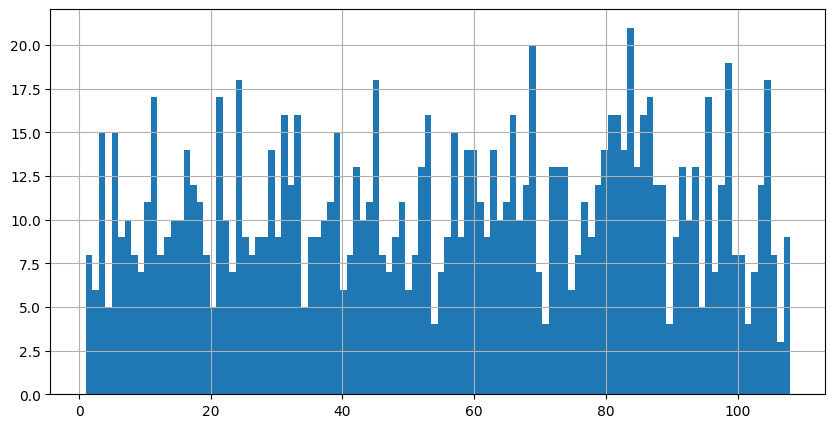

In [198]:
ratings["img"].hist(bins=max(ratings["img"]))

# Ratings Distribution

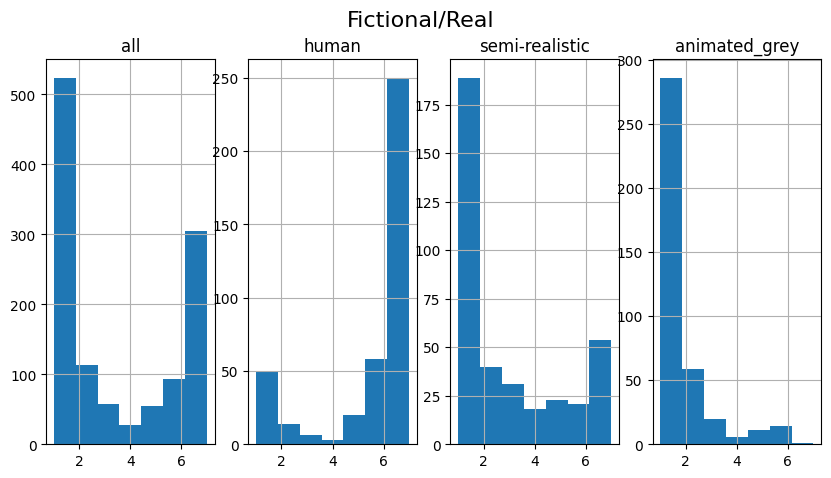

Human: 5.76, Semi Realistic: 2.80, Cartoon: 1.60, Anova p-value: 0.00, Mann–Whitney p-value: 0.00 (s vs h+c)


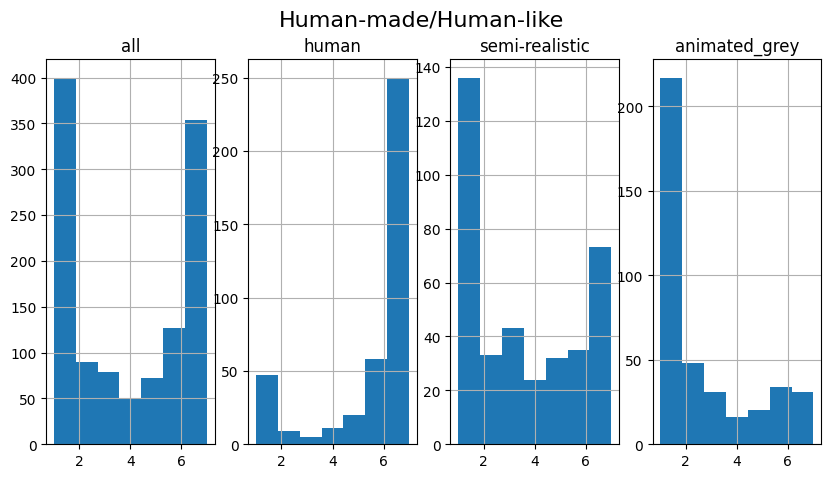

Human: 5.80, Semi Realistic: 3.48, Cartoon: 2.50, Anova p-value: 0.00, Mann–Whitney p-value: 0.00 (s vs h+c)


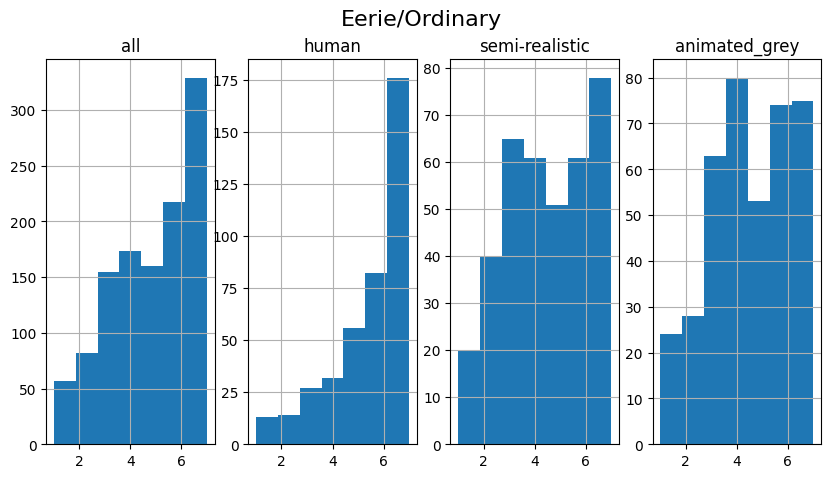

Human: 5.63, Semi Realistic: 4.54, Cartoon: 4.59, Anova p-value: 0.00, Mann–Whitney p-value: 0.00 (s vs h+c)


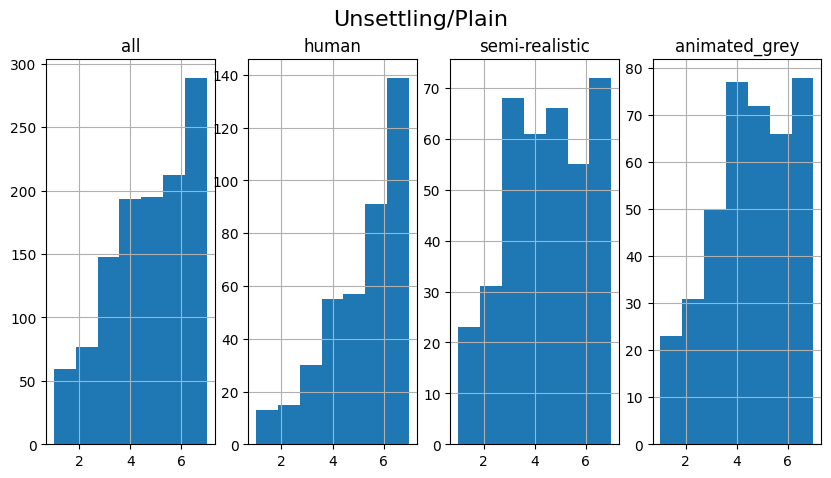

Human: 5.39, Semi Realistic: 4.51, Cartoon: 4.65, Anova p-value: 0.00, Mann–Whitney p-value: 0.00 (s vs h+c)


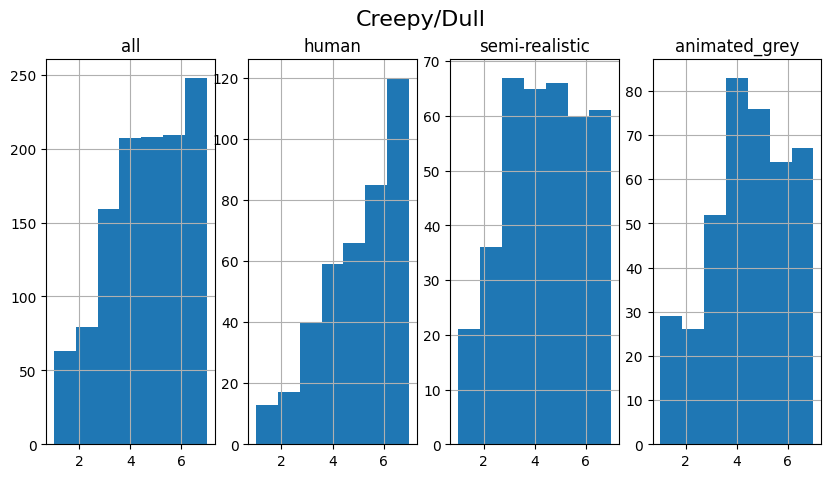

Human: 5.21, Semi Realistic: 4.44, Cartoon: 4.54, Anova p-value: 0.00, Mann–Whitney p-value: 0.00 (s vs h+c)


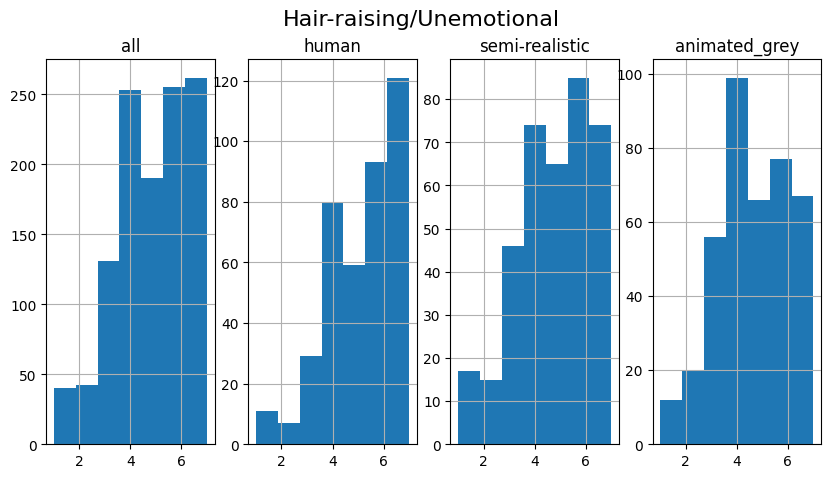

Human: 5.33, Semi Realistic: 4.88, Cartoon: 4.73, Anova p-value: 0.00, Mann–Whitney p-value: 0.18 (s vs h+c)


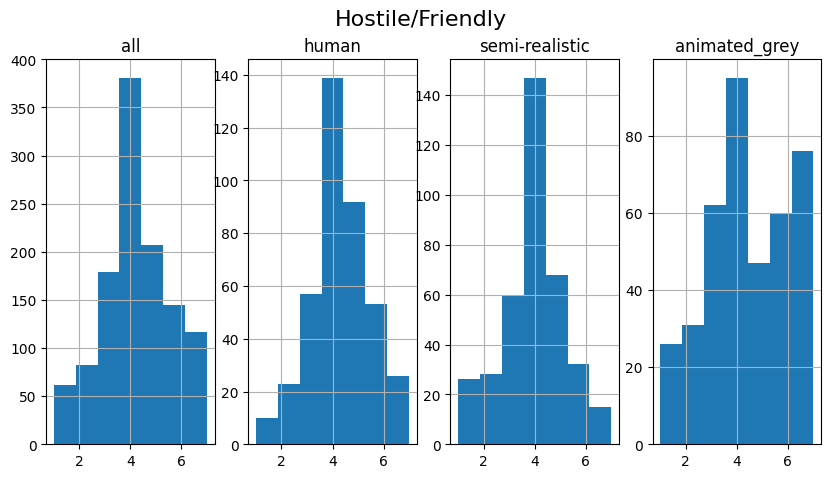

Human: 4.36, Semi Realistic: 3.95, Cartoon: 4.49, Anova p-value: 0.00, Mann–Whitney p-value: 0.00 (s vs h+c)


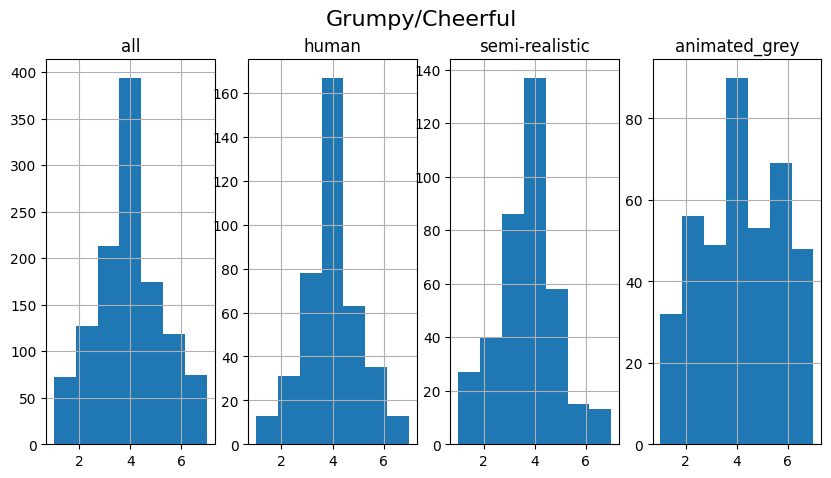

Human: 3.98, Semi Realistic: 3.68, Cartoon: 4.20, Anova p-value: 0.00, Mann–Whitney p-value: 0.00 (s vs h+c)


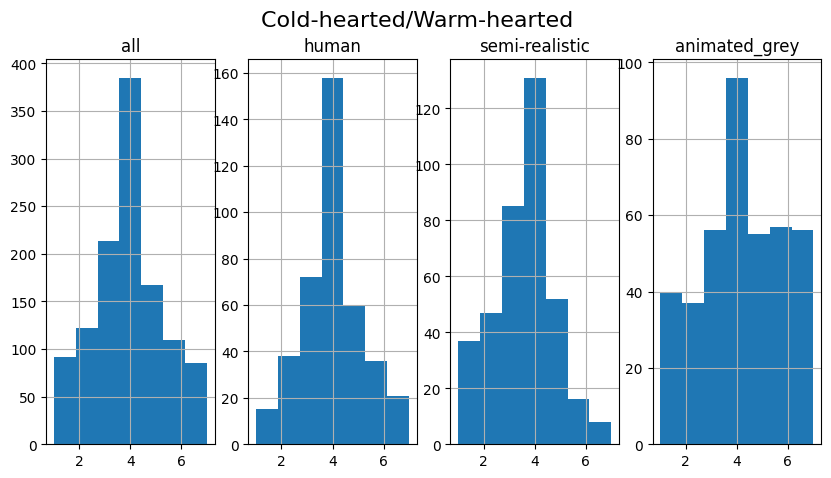

Human: 4.00, Semi Realistic: 3.52, Cartoon: 4.22, Anova p-value: 0.00, Mann–Whitney p-value: 0.00 (s vs h+c)


In [199]:
for column in questions:
    fig, axes = plt.subplots(1, 4)
    fig.suptitle(column, fontsize=16)
    ratings[column].hist(bins=max(ratings[column]), ax=axes[0])
    axes[0].set_title('all')
    ratings[ratings["type"] == "human"][column].hist(bins=1 + max(ratings[column]) - min(ratings[column]), ax=axes[1])
    axes[1].set_title('human')
    ratings[ratings["type"] == "semi-realistic"][column].hist(bins=1 + max(ratings[column]) - min(ratings[column]),
                                                              ax=axes[2])
    axes[2].set_title('semi-realistic')
    ratings[ratings["type"] == "animated_grey"][column].hist(bins=1 + max(ratings[column]) - min(ratings[column]),
                                                             ax=axes[3])
    axes[3].set_title('animated_grey')
    plt.show()
    f, f_p = scipy.stats.f_oneway(ratings[ratings["type"] == "human"][column],
                                  ratings[ratings["type"] == "semi-realistic"][column],
                                  ratings[ratings["type"] == "animated_grey"][column])
    u, u_p = scipy.stats.mannwhitneyu(ratings[ratings["type"] == "semi-realistic"][column],
                                      ratings[(ratings["type"] == "human") | (ratings["type"] == "animated_grey")][
                                          column])

    print(
        "Human: {:.2f}, Semi Realistic: {:.2f}, Cartoon: {:.2f}, Anova p-value: {:.2f}, Mann–Whitney p-value: {:.2f} (s vs h+c)".format(
            ratings[ratings["type"] == "human"][column].mean(),
            ratings[ratings["type"] == "semi-realistic"][column].mean(),
            ratings[ratings["type"] == "animated_grey"][column].mean(), f_p, u_p))
